# Chapter 13 - Beta and SML
---

In [1]:
# Preamble
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
from urllib.request import Request, urlopen as uReq
import re
import tenacity
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf  # This gets us prices from Yahoo finance. See https://pypi.org/project/yfinance/
import statsmodels.api as sm
import statsmodels.formula.api as smf
from tabulate import tabulate


@tenacity.retry(wait=tenacity.wait_exponential(multiplier=1, min=4, max=64), stop=tenacity.stop_after_attempt(5))
def get_that_page(url):
    try:
        req = Request(url, headers={'User-Agent': 'Mozilla/5.0'})
        uClient = uReq(req)
        print('Success')
    except Exception:
        print('Trying again.')
    return uClient


def do_table(url):
    uClient = get_that_page(url)
    soup = BeautifulSoup(uClient, 'lxml')
    table = soup.find('table', class_='instruments-table')
    table_headers =[]
    for tx in soup.find_all('th'):
        table_headers.append(tx.get('id'))

    filler = ['unknown', 'pct']
    data = []
    rows = table.find_all('tr')
    for row in rows:
        cols = row.find_all('td')
        cols = [ele.text.strip() for ele in cols]
        #print(cols)
        if len(cols)>0:
            data.append(cols)
    df = pd.DataFrame(data, columns=[x if x!=None else filler.pop() for x in table_headers])
    lyst = ['price', 'volume', 'value', 'outstanding_capitalisation', 'market_capitalisation', 'pct', 'trade_count']
    df[lyst] = df[lyst].replace({'\$': '', ',': ''}, regex=True).apply(pd.to_numeric,  errors='coerce')
    df['green_bond']= df['green_bond'].map({'false': 0, 'true': 1})
    df = df[~df['company'].str.contains('Smartshares')]
    df['code'] = df['code']+".NZ"
    nzx = df['code'].to_list()

    return(df[df['market_capitalisation']>0], nzx)


def set_xmargin(ax, left=0.0, right=0.3):
    ax.set_xmargin(0)
    ax.autoscale_view()
    lim = ax.get_xlim()
    delta = np.diff(lim)
    left =  lim[0] - delta*left
    right = lim[1] + delta*right
    ax.set_xlim(left,right)


def nice_print(df, k=1, name=""):
    if isinstance(df, pd.DataFrame):
        print(tabulate(k*df, tablefmt="fancy_grid", floatfmt=".4f", headers="keys"))
    elif isinstance(df, pd.Series):
        df.name= name
        df=df.to_frame()
        print(tabulate(k*df, tablefmt="fancy_grid", floatfmt=".4f", headers="keys"))

---

**Webscraping the NZX**

---

In [2]:
dfm, nzx  = do_table('https://www.nzx.com/markets/NZSX')

Success


In [3]:
def closing_prics(nzx, start, end):
    dfy = yf.download(nzx, start, end, progress=True, interval="1mo")
    df_close = dfy['Adj Close'].copy()
    df_close.dropna(how = 'all', inplace=True, axis = 1)
    df_close.sort_index(inplace=True)
    #df_close.dropna(how='all').pct_change().add(1).cumprod().mean(axis=1).sub(1).plot()
    df_close.index = pd.to_datetime(df_close.index, format ='%Y-%m-%d')
    df_close.columns = [re.sub(r'.NZ$|\^', "", x) for x in list(df_close)]
    return list(df_close), df_close.resample('M').last()

nzx_set, df_close = closing_prics(nzx+['^NZ50'], '2017-03-31', '2022-04-30')
#nzx_set, df_close = returns(nzx+['^NZ50'], '2015-01-01', '2019-12-30')

[*********************100%***********************]  152 of 152 completed

9 Failed downloads:
- FCT.NZ: No data found for this date range, symbol may be delisted
- MLNWE.NZ: No data found, symbol may be delisted
- KFLWG.NZ: No data found, symbol may be delisted
- NTLOB.NZ: No data found, symbol may be delisted
- AKL.NZ: No data found, symbol may be delisted
- BIF.NZ: No data found for this date range, symbol may be delisted
- JPG.NZ: No data found for this date range, symbol may be delisted
- PLP.NZ: No data found for this date range, symbol may be delisted
- CO2.NZ: No data found for this date range, symbol may be delisted


In [4]:
df_close.sample(5)

,ACE,AFC,AFI,AFT,AGL,AIA,AIR,ALF,ANZ,APL,...,VGL,VHP,VNT,VSL,VTL,WBC,WDT,WHS,WIN,NZ50
Date,,,,,,,,,,,,,,,,,,,,,
2020-04-30,0.20,0.001,6.472195,4.25,1.360418,6.090000,1.345000,0.540435,16.942127,0.383035,...,1.250000,2.280007,NaN,NaN,0.650096,16.165855,0.1081,1.861289,NaN,10532.070312
2021-02-28,0.10,0.001,6.605446,4.21,1.286882,7.550000,1.590000,0.520000,27.334959,0.326617,...,1.700000,2.978142,NaN,NaN,0.718857,24.441559,0.0910,3.052788,NaN,12227.290039
2020-12-31,0.20,0.001,6.605446,5.51,1.250114,7.580000,1.800000,0.579739,23.879150,0.326965,...,1.680000,3.153727,NaN,NaN,0.728571,19.954239,0.0770,2.506020,NaN,13091.639648
2022-04-30,0.06,0.001,6.940000,3.60,2.050000,7.835000,0.885000,0.800000,29.850000,0.290000,...,1.870000,3.102180,3.25,10.02,0.305000,26.110001,0.1570,3.450000,3.26,11884.299805
2017-03-31,0.10,0.004,6.053573,2.65,1.911979,6.045352,1.853158,0.526126,28.244556,0.442920,...,2.743448,1.721081,NaN,NaN,0.784366,30.431917,0.2375,1.609319,NaN,7196.779785


---

**Obtain list of share prices and calculate returns**

---

<AxesSubplot:xlabel='Date'>

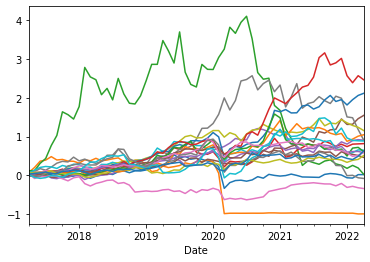

In [5]:
market = 'NZ50'
stocks_list = ["AIR", "FPH", "MEL", "AIA", "SPK", "MCY", "MFT", "EBO", "CEN", "IFT", "FBU", "RYM", "POT", "VCT", "ATM", "CNU", "GMT", "GNE", "SUM", "PCT", "NZ50"]
stocks_list.sort()
data = df_close[stocks_list]
data.sample(5)
# Calculate monthly returns
day_ret = np.log(data).diff().dropna()
day_ret.add(1).cumprod().sub(1).plot(legend=False)

---

**Loading Benninga's data**

---

In [6]:
day_ret = pd.read_csv('Chapt13_ret_data.csv')
day_ret['Date'] =  pd.to_datetime(day_ret['Date'])
day_ret.set_index('Date', inplace=True)
day_ret.head(5)
market = "GSPC"

**The following prepares the data in such a way that we can run regressions per firm.**

- It separates out the index,
- Then it melts the data into a long single column,
- After which it matches the returns per day,
- The output is a panel with $ri$ and $rm$.


In [7]:
def shape_data(day_ret, idxvar, idxcolumn):
    # make sure we have the right data
    if idxvar in list(day_ret):
        print("Right source")
        if isinstance(idxcolumn, pd.Series):   
            dfi = idxcolumn
            print("Series")    
        else: 
            dfi = day_ret[[idxvar]] 
            print("Label, market: "+ idxvar)    
    else:
        print("Wrong source")
        return
    df = (day_ret[[x for x in list(day_ret) if x!=idxvar]]
          .copy()
          .reset_index()
          .melt(id_vars=['Date']).set_index('Date')
          .join(dfi)
          .reset_index()
          .sort_values(by=['variable', 'Date'])
          .set_index('variable')
          .sort_index()
          .rename(columns={'value': 'ri', idxvar: 'rm', 'prop_return': 'beta'})
          )
    return df

df = shape_data(day_ret, market, "")
#df = shape_data(day_ret, 'NZ50', "")
df.head(3)

Right source
Label, market: GSPC


,Date,ri,rm
variable,,,
AAPL,2014-07-01,0.028326,-0.015195
AAPL,2014-08-01,0.069690,0.036964
AAPL,2014-09-01,-0.012259,-0.015635


**The function below runs a regression on two columns of a frame**

In [8]:
def regress(data, yvar, xvars):
    Y = data[yvar]
    X = data[xvars]
    X['intercept'] = 1.
    result = sm.OLS(Y, X).fit()
    return result.params

**Running the first pass regression**

In [9]:
dfb = df.groupby('variable').apply(regress, 'ri', ['rm'])
dfb.T

variable,AAPL,AXP,BA,CAT,CSCO,CVX,DIS,GS,HD,IBM,...,PFE,PG,TRV,UNH,UTX,V,VZ,WBA,WMT,XOM
rm,1.140132,1.113747,1.271783,1.544307,1.178480,0.938560,0.959794,1.220915,1.093766,1.215198,...,0.605161,0.387271,0.999642,0.626394,1.264835,0.951057,0.453350,0.722565,0.342315,0.927823
intercept,0.005561,-0.001853,0.011529,-0.004301,0.008296,-0.004218,0.002950,-0.004310,0.009839,-0.009384,...,0.005149,0.004977,0.003533,0.015838,-0.003685,0.014183,0.002986,-0.009151,0.005212,-0.008072


**Second pass regression needs the mean returns**

In [10]:
dfr = df['ri'].groupby('variable').mean()
dfr.to_frame().T

variable,AAPL,AXP,BA,CAT,CSCO,CVX,DIS,GS,HD,IBM,...,PFE,PG,TRV,UNH,UTX,V,VZ,WBA,WMT,XOM
ri,0.012008,0.004445,0.01872,0.004432,0.01496,0.001089,0.008378,0.002594,0.016024,-0.002512,...,0.008572,0.007167,0.009186,0.01938,0.003467,0.019561,0.00555,-0.005065,0.007148,-0.002826


**Second pass regression needs the mean returns, combined with the betas**

In [11]:
dfb = dfb['rm'].to_frame().join(dfr)
dfb.rename(columns = {'rm': 'beta'}, inplace=True)
dfb.T

variable,AAPL,AXP,BA,CAT,CSCO,CVX,DIS,GS,HD,IBM,...,PFE,PG,TRV,UNH,UTX,V,VZ,WBA,WMT,XOM
beta,1.140132,1.113747,1.271783,1.544307,1.17848,0.938560,0.959794,1.220915,1.093766,1.215198,...,0.605161,0.387271,0.999642,0.626394,1.264835,0.951057,0.45335,0.722565,0.342315,0.927823
ri,0.012008,0.004445,0.018720,0.004432,0.01496,0.001089,0.008378,0.002594,0.016024,-0.002512,...,0.008572,0.007167,0.009186,0.019380,0.003467,0.019561,0.00555,-0.005065,0.007148,-0.002826


### Plotting the second pass regression: ###

In [12]:
def scattplot(X, Y, returns):
    def plotlabel(beta, ri, variable):
        ax.text(beta+0.005, ri, variable)
    results = smf.ols(Y + ' ~ 1 + ' + X, data=returns).fit()
    fig = plt.figure(figsize=(10,10))
    ax = sns.regplot(x=X, y=Y, data=returns, scatter_kws={'s':5})
    set_xmargin(ax, left=0, right=0)
    
    # Titles and axes names
    ax.set_title(r'Monthly Returns')
    ax.set_xlabel(X)
    ax.set_ylabel(Y)
    plt.grid(linestyle="dotted", color='grey')
    # Equation
    plusmin = '-' if results.params.Intercept<0 else '+'
    equation = f'${{{Y}}}$ =  {results.params[1]:.3f} ${{{X}}}$ {plusmin} {abs(results.params.Intercept):.3f}'
    ax.text(y = returns[Y].max(), x = returns[X].min(), s = equation)
    
    dfc = dfb.reset_index()
    dfc.apply(lambda x: plotlabel(x['beta'],  x['ri'], x['variable']), axis=1)
    plt.show()
    print(results.summary())
    return


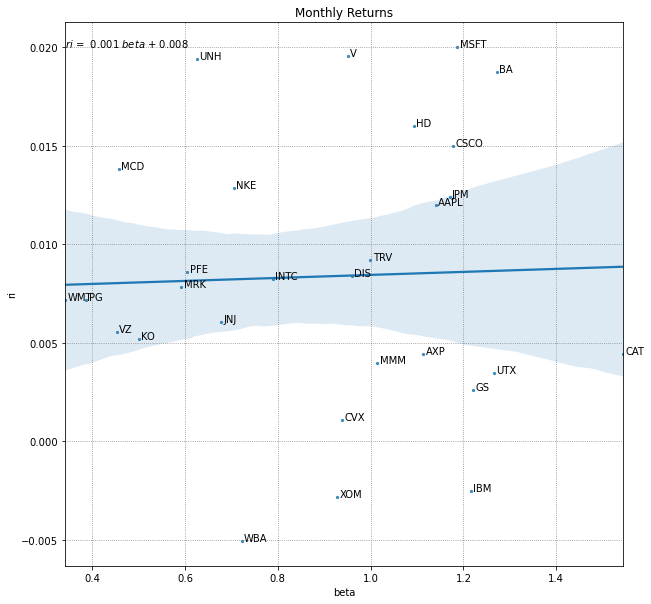

                            OLS Regression Results                            
Dep. Variable:                     ri   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.036
Method:                 Least Squares   F-statistic:                   0.03448
Date:                Mon, 16 May 2022   Prob (F-statistic):              0.854
Time:                        13:53:12   Log-Likelihood:                 104.24
No. Observations:                  29   AIC:                            -204.5
Df Residuals:                      27   BIC:                            -201.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0077      0.004      1.965      0.0

In [13]:
scattplot('beta','ri', dfb)

### The Non-Efficiency of the "Market Portfolio" ###
**Calculate Envelope Portfolio proportions in one step (FROM CHAPTER 11)***

**First calculate return vector**

In [14]:
idxvar = market
lyst = [x for x in list(day_ret) if x!=idxvar]
dfs = day_ret[lyst].cov()              
dfr = day_ret[lyst].mean()
dfr.name= 'Returns'
dfr.to_frame().T

,MSFT,AAPL,V,JNJ,JPM,XOM,WMT,PG,DIS,PFE,...,MCD,NKE,IBM,UTX,AXP,MMM,CAT,GS,WBA,TRV
Returns,0.020014,0.012008,0.019561,0.006036,0.012422,-0.002826,0.007148,0.007167,0.008378,0.008572,...,0.013833,0.012856,-0.002512,0.003467,0.004445,0.00396,0.004432,0.002594,-0.005065,0.009186


### Function: Calculate Envelope Portfolio proportions in one step ###
**See also this link from [Auke Plantinga](https://www.youtube.com/watch?v=OGhGz8trZtw)**

The function relies on the Sharpe ratio, see appendix to Chapter 11. 



<AxesSubplot:title={'center':'Proportions'}>

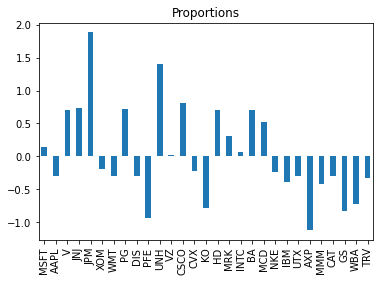

In [15]:
def envelope_portfolio_df(dfs, dfr, constant):
    df_inv = pd.DataFrame(np.linalg.pinv(dfs.values), dfs.columns, dfs.columns)
    ex_ret = dfr - constant
    Z = df_inv @ ex_ret
    return Z/Z.sum() # Efficient Portfolio proportions
port_v_prop = envelope_portfolio_df(dfs, dfr, 0.0006432)
port_v_prop.to_frame().T
port_v_prop.plot(kind = 'bar', title = "Proportions")

In [16]:
port_v_ret = day_ret[lyst] @ port_v_prop   # Returns n dates x k firms @ k firms x 1 = weighted returns per date
port_v_ret.name = "prop_return"
port_v_var = port_v_prop @ dfs @ port_v_prop # Portfolio variances and covariances
port_v_sigma = port_v_var**.5

**Weighted returns, efficient portfolio returns, per date:**

In [17]:
port_v_ret.to_frame().T

Date,2019-05-31,2019-05-01,2019-04-01,2019-03-01,2019-02-01,2019-01-01,2018-12-01,2018-11-01,2018-10-01,2018-09-01,...,2015-04-01,2015-03-01,2015-02-01,2015-01-01,2014-12-01,2014-11-01,2014-10-01,2014-09-01,2014-08-01,2014-07-01
prop_return,-0.021879,0.088612,0.19445,0.083659,0.063533,0.0574,0.012948,0.199997,0.019648,-0.066573,...,-0.024016,-0.001409,0.152733,0.125511,0.029686,0.085476,0.100346,0.098786,0.265056,0.156193


**Efficient portfolio returns per date combined with efficient portfolio returns**

In [18]:
df = shape_data(day_ret, market, port_v_ret)
print(df.head(3))
print(df.shape)

Right source
Series
               Date        ri      beta
variable                               
AAPL     2014-07-01  0.028326  0.156193
AAPL     2014-08-01  0.069690  0.265056
AAPL     2014-09-01 -0.012259  0.098786
(1740, 3)


**Running the first pass regression**

In [19]:
dfb = df.groupby('variable').apply(regress, 'ri', ['beta'])
dfb.T

variable,AAPL,AXP,BA,CAT,CSCO,CVX,DIS,GS,HD,IBM,...,PFE,PG,TRV,UNH,UTX,V,VZ,WBA,WMT,XOM
beta,0.125963,0.042136,0.200351,0.041993,0.158676,0.004942,0.085725,0.021616,0.170469,-0.034970,...,0.087871,0.072309,0.094676,0.20766,0.031299,0.209674,0.054383,-0.063261,0.072094,-0.038444
intercept,0.000562,0.000616,0.000514,0.000616,0.000541,0.000640,0.000588,0.000629,0.000534,0.000666,...,0.000587,0.000597,0.000582,0.00051,0.000623,0.000508,0.000608,0.000684,0.000597,0.000668


**Second pass regression needs the mean returns**

In [20]:
dfr = df['ri'].groupby('variable').mean()
dfr.to_frame().T

variable,AAPL,AXP,BA,CAT,CSCO,CVX,DIS,GS,HD,IBM,...,PFE,PG,TRV,UNH,UTX,V,VZ,WBA,WMT,XOM
ri,0.012008,0.004445,0.01872,0.004432,0.01496,0.001089,0.008378,0.002594,0.016024,-0.002512,...,0.008572,0.007167,0.009186,0.01938,0.003467,0.019561,0.00555,-0.005065,0.007148,-0.002826


**Second pass regression needs the mean returns, combined with the betas**

In [21]:
dfb = dfb['beta'].to_frame().join(dfr)
dfb.T

variable,AAPL,AXP,BA,CAT,CSCO,CVX,DIS,GS,HD,IBM,...,PFE,PG,TRV,UNH,UTX,V,VZ,WBA,WMT,XOM
beta,0.125963,0.042136,0.200351,0.041993,0.158676,0.004942,0.085725,0.021616,0.170469,-0.034970,...,0.087871,0.072309,0.094676,0.20766,0.031299,0.209674,0.054383,-0.063261,0.072094,-0.038444
ri,0.012008,0.004445,0.018720,0.004432,0.014960,0.001089,0.008378,0.002594,0.016024,-0.002512,...,0.008572,0.007167,0.009186,0.01938,0.003467,0.019561,0.005550,-0.005065,0.007148,-0.002826


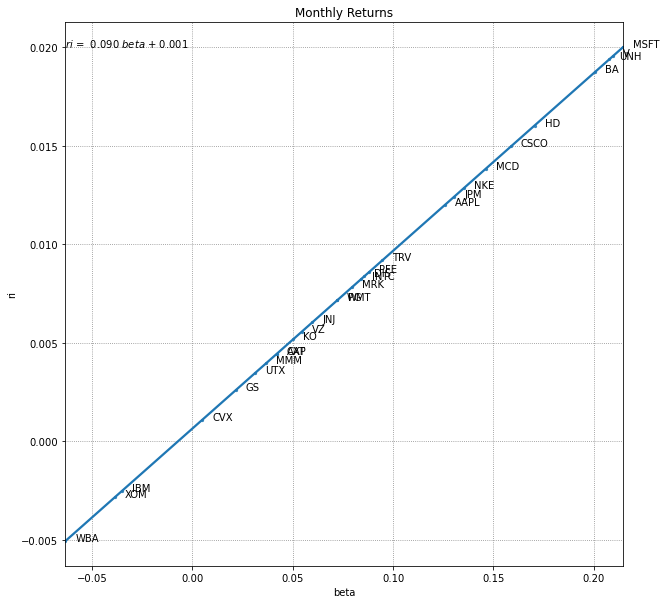

                            OLS Regression Results                            
Dep. Variable:                     ri   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 4.547e+30
Date:                Mon, 16 May 2022   Prob (F-statistic):               0.00
Time:                        13:53:13   Log-Likelihood:                 1080.0
No. Observations:                  29   AIC:                            -2156.
Df Residuals:                      27   BIC:                            -2153.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0006   4.78e-18   1.35e+14      0.0

In [22]:
scattplot('beta','ri', dfb)